# Telco Customer Churn Prediction Kale

In this [Kaggle competition](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) 

>In this competition, your goal is to analyze behavior to retain customers and predict churning. You can analyze all relevant customer data and develop focused customer retention programs.

# Install necessary packages

We can install the necessary package by either running `pip install --user <package_name>` or include everything in a `requirements.txt` file and run `pip install --user -r requirements.txt`. We have put the dependencies in a `requirements.txt` file so we will use the former method.

> NOTE: Do not forget to use the `--user` argument. It is necessary if you want to use Kale to transform this notebook into a Kubeflow pipeline.
After installing python packages, restart notebook kernel before proceeding.


In [1]:
!pip install -r requirements.txt --quiet

# Imports

In this section we import the packages we need for this example. Make it a habit to gather your imports in a single place.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import wget, os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [3]:
# Set random seed for reproducibility and ignore warning messages.
np.random.seed(22)

# Download and load the dataset

In this section, we download the data from kaggle to get it in a ready-to-use form by the model. 

First, let us load and analyze the data.

The data is in csv format, thus, we use the handy read_csv pandas method.

In [4]:
# download files
data_path = os.getcwd()

# data link
data_link = 'https://raw.githubusercontent.com/kubeflow/examples/master/telco-customer-churn-kaggle-competition/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# download data
wget.download(data_link, f'{data_path}/WA_Fn-UseC_-Telco-Customer-Churn.csv')

'/home/jovyan/WA_Fn-UseC_-Telco-Customer-Churn (1).csv'

In [5]:
# read data
data = pd.read_csv(f'{data_path}/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Let us now explore the data

In [6]:
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [7]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Total charges column data type should be of datatype `float`

# Transform Data

In [8]:
# remove rows with spaces
data = data[data['TotalCharges'] !=' '].copy()

In [9]:
# 11 rows removed
data.shape

(7032, 21)

In [10]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [11]:
# check for data cardinality
lis3=[]
for i in data:
    lis3.append(data[str(i)].nunique())

cardinal=pd.DataFrame(zip(data.columns, lis3), columns=['Features', 'cardinality'])

In [12]:
cardinal

,Features,cardinality
0,customerID,7032
1,gender,2
2,SeniorCitizen,2
3,Partner,2
4,Dependents,2
5,tenure,72
6,PhoneService,2
7,MultipleLines,3
8,InternetService,3
9,OnlineSecurity,3


In [13]:
# get columns with unique values less than 5 for discrete variable EDA
cols=[]
for i in data:
  if data[str(i)].nunique() < 5:
    cols.append(i)

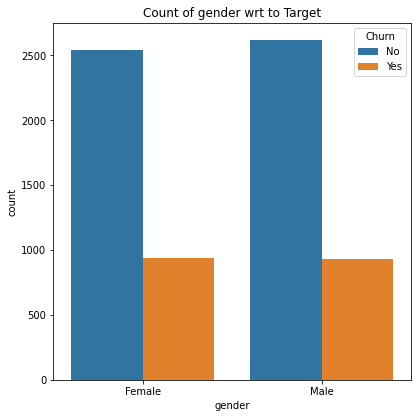

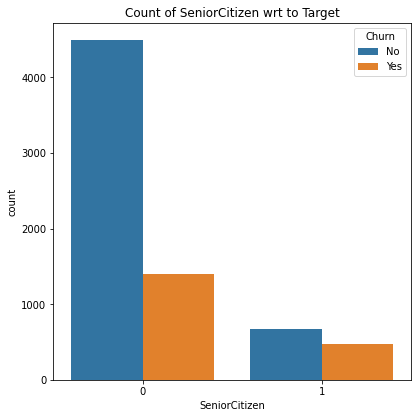

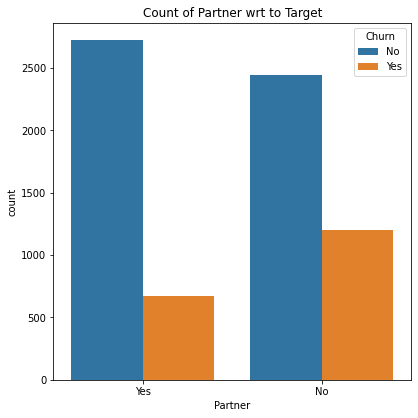

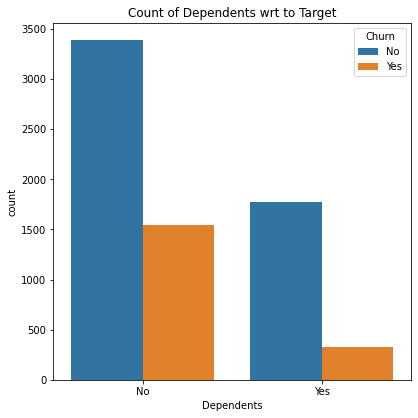

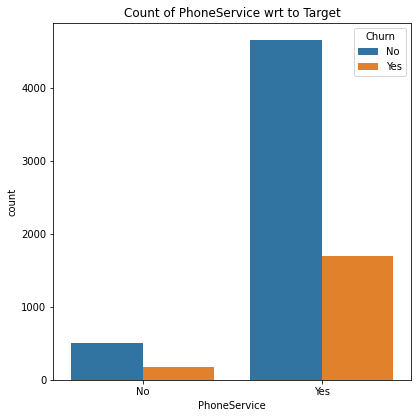

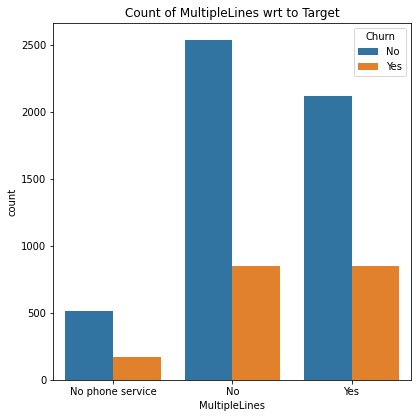

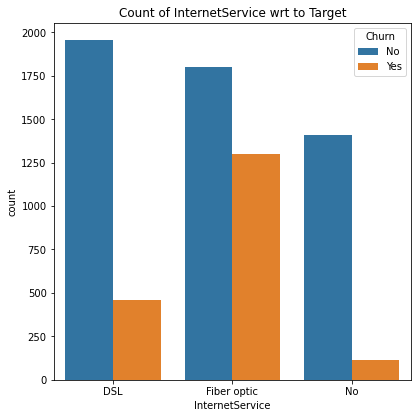

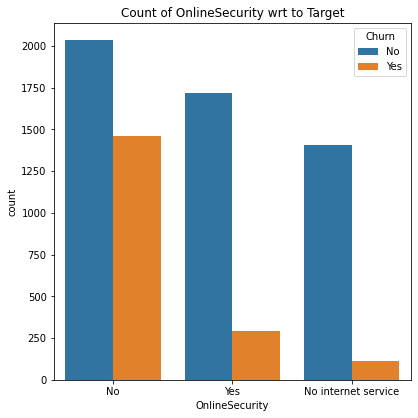

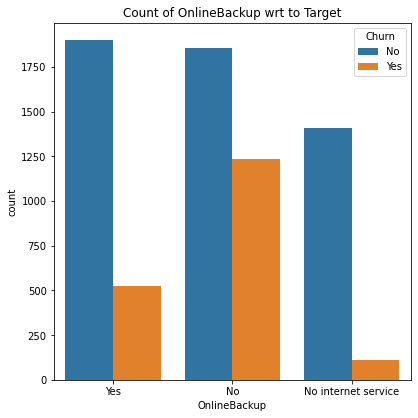

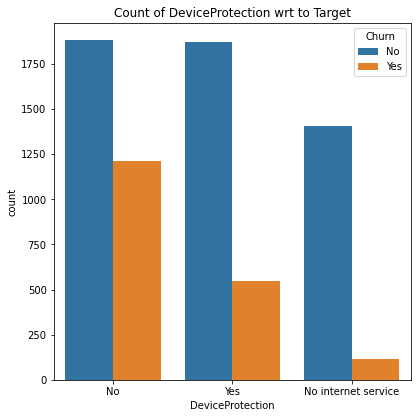

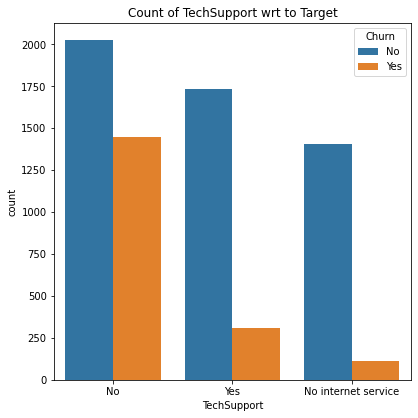

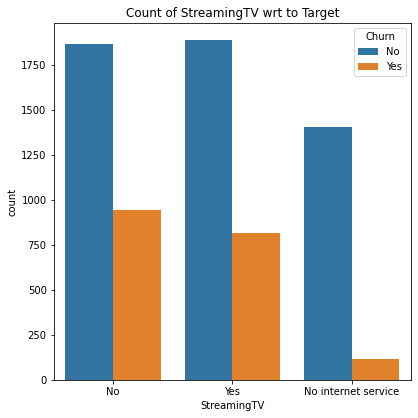

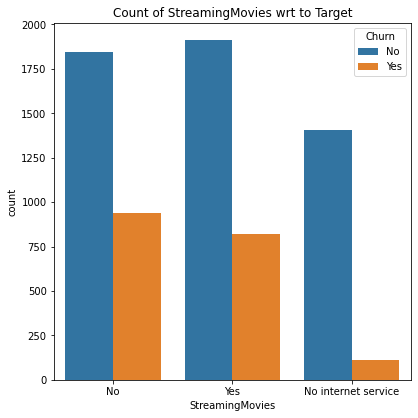

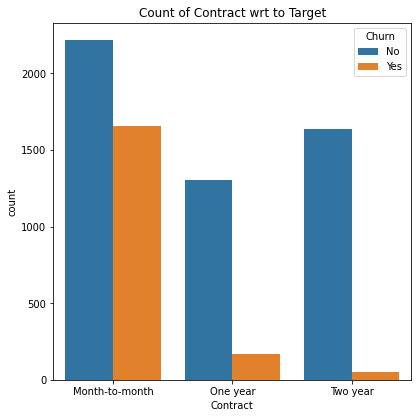

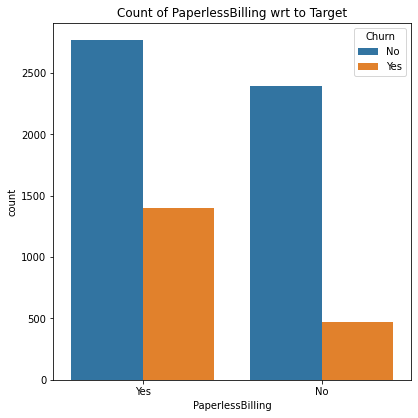

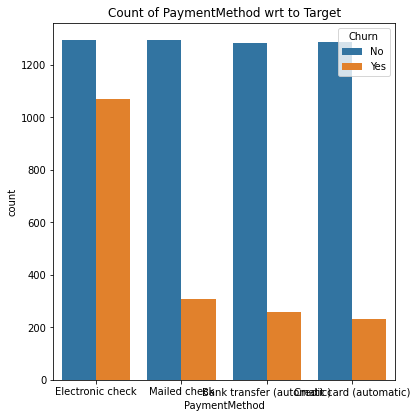

In [14]:
# Check how the frequency varies with the target
for i in data[cols]:
  if i != ('Churn'):
    plt.figure(figsize=(6,6))
    sns.countplot(x=data[i], hue=data['Churn'])
    plt.title(f'Count of {i} wrt to Target')
    plt.tight_layout(pad=1.4)
    plt.show()

Observations:

* Majority of folks with phones that don't have access to internet services tend to have longer retention span
* Customers with a one year contract or two year contract tend to stay on the telco longer

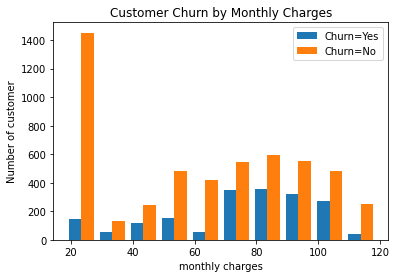

In [15]:
# Customer churn by monthly charges
mc_churn_yes= data[data.Churn=='Yes'].MonthlyCharges
mc_churn_no= data[data.Churn=='No'].MonthlyCharges

plt.xlabel("monthly charges")
plt.ylabel("Number of customer")
plt.title("Customer Churn by Monthly Charges")
plt.hist([mc_churn_yes,mc_churn_no], label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

The distribution is skewed to the left.

Customers with less monthly charges tend to stay on the telco longer

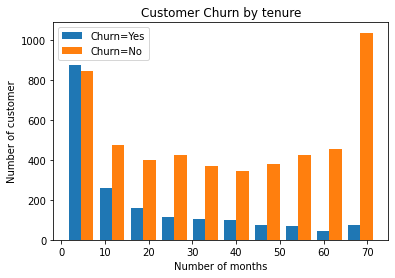

In [16]:
# Customer Churn by tenure
tenure_churn_yes= data[data.Churn=='Yes'].tenure
tenure_churn_no= data[data.Churn=='No'].tenure

plt.xlabel("Number of months")
plt.ylabel("Number of customer")
plt.title("Customer Churn by tenure")
plt.hist([tenure_churn_yes, tenure_churn_no], label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

The longer the tenure period the more likely the customer will stay 

In [17]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [18]:
# convert Churn targe from string to integers
# replace no with 1 and yes with 0
data['Churn'] = data['Churn'].replace({'No':1, 'Yes':0})

# Feature Engineering

Grouping the tenure, monthly charge and total charge column into different segments

In [19]:
def yearly_tenure(tenure):
  if tenure <= 12:
      return 1
  elif tenure >12 and tenure <=24:
      return 2
  elif tenure >24 and tenure <=36:
      return 3
  elif tenure >36 and tenure <=48:
      return 4
  elif tenure >48 and tenure <=60:
      return 5
  elif tenure > 60 and tenure <=72:
      return 6

In [20]:
def monthly_charge_plan(charge):
  if charge <= 35:
      return 'Basic'
  elif charge>35 and charge <= 80:
      return 'Advanced'
  elif charge>80:
      return 'Premium'

In [21]:
def total_charge_status(charge):
  if charge <= 250:
      return 'V-low'
  elif charge > 250 and charge <= 450:
      return 'low'
  elif charge > 450 and charge <= 1500:
      return 'medium'
  elif charge > 1500 and charge <= 3500:
      return 'High'
  elif charge > 3500:
      return 'V-High'

In [22]:
# generating new features
data['OnlineSecurityBackup'] = data['OnlineSecurity'] + data['OnlineBackup']
data['OnlineSecurityDevice'] = data['OnlineSecurity'] + data['DeviceProtection']
data['Streaming'] = data['StreamingMovies'] + data['StreamingTV']

In [23]:
# applying grouping functions to create new features
data['yearly_tenure'] = data['tenure'].apply(yearly_tenure)
data['MonthlyChargesplan'] = data['MonthlyCharges'].apply(monthly_charge_plan)
data['TotalChargestatus'] = data['TotalCharges'].apply(total_charge_status)

In [24]:
# drop customerID
data = data.drop('customerID', axis=1)

In [25]:
# scale 'MonthlyCharges' and 'TotalCharges' columns
scaler = MinMaxScaler()
data[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(data[['MonthlyCharges', 'TotalCharges']])

In [26]:
# one-hot encode categorical variables 
X = pd.get_dummies(data.drop(columns=['Churn']), drop_first=True)
y= data['Churn']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22, stratify=y)

# Modelling

## Catboost

In [28]:
# compute class weight to handle imbalance nature
class_weight = dict(zip(np.unique(y), class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y), y=y))) 

In [29]:
# initialization
cb=CatBoostClassifier(class_weights=class_weight, n_estimators=150,
                      eval_metric='AUC', learning_rate=0.1043242,
                      max_depth=5, use_best_model=True, random_state=22, 
                      allow_writing_files=False, metric_period=20)

# fitting
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.8289318	best: 0.8289318 (0)	total: 51.2ms	remaining: 7.62s
20:	test: 0.8536616	best: 0.8536616 (20)	total: 109ms	remaining: 668ms
40:	test: 0.8535645	best: 0.8536616 (20)	total: 172ms	remaining: 458ms
60:	test: 0.8532652	best: 0.8536616 (20)	total: 225ms	remaining: 328ms
80:	test: 0.8521779	best: 0.8536616 (20)	total: 278ms	remaining: 237ms
100:	test: 0.8510674	best: 0.8536616 (20)	total: 333ms	remaining: 161ms
120:	test: 0.8494486	best: 0.8536616 (20)	total: 387ms	remaining: 92.6ms
140:	test: 0.8474856	best: 0.8536616 (20)	total: 441ms	remaining: 28.1ms
149:	test: 0.8467873	best: 0.8536616 (20)	total: 466ms	remaining: 0us

bestTest = 0.8536615707
bestIteration = 20

Shrink model to first 21 iterations.


In [30]:
# predict
cb_pred = cb.predict(X_test)

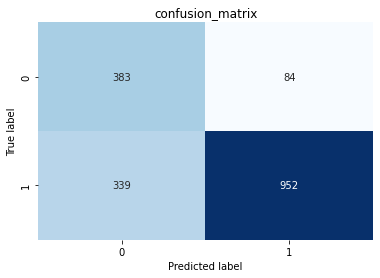

In [31]:
# plot confusion_matrix
cb_cm = confusion_matrix(y_test, cb_pred)
sns.heatmap(cb_cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Xgboost

In [32]:
# initialization
xgb=XGBClassifier(scale_pos_weight=0.3627, max_depth=10, 
                  learning_rate=0.1043242, n_estimators=600, 
                  colsample_bylevel=0.8, reg_alpha=0.8,
                  silent=True, metrics='auc', random_state=22)
# fitting
xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=50,verbose=50)

[14:21:00] WARNING: ../src/learner.cc:576: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65247	validation_1-logloss:0.65756
[50]	validation_0-logloss:0.30319	validation_1-logloss:0.46641
[100]	validation_0-logloss:0.24431	validation_1-logloss:0.47187
[108]	validation_0-logloss:0.23954	validation_1-logloss:0.47214


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1043242,
              max_delta_step=0, max_depth=10, metrics='auc', min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=16, num_parallel_tree=1, predictor='auto', random_state=22,
              reg_alpha=0.8, reg_lambda=1, scale_pos_weight=0.3627, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
# predict
xgb_pred = xgb.predict(X_test)

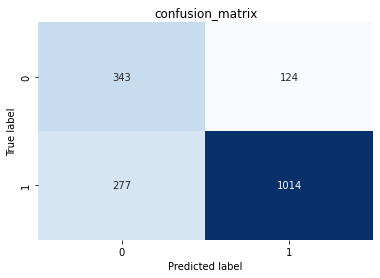

In [34]:
# plot confusion_matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(xgb_cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## LightGBM

In [35]:
# initialization
lgbm = LGBMClassifier(random_state=22,scale_pos_weight=0.362)

# fitting
lgbm.fit(X_train, y_train, categorical_feature = 'auto', eval_set=(X_test, y_test),feature_name='auto', verbose=0)

LGBMClassifier(random_state=22, scale_pos_weight=0.362)

In [36]:
# predict
lgbm_pred = lgbm.predict(X_test)

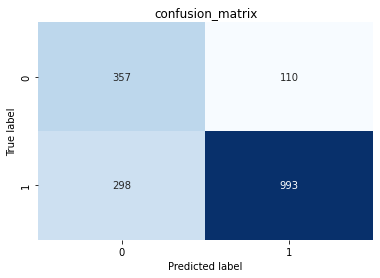

In [37]:
# plot confusion matrix
lgbm_cm = confusion_matrix(y_test, lgbm_pred)
sns.heatmap(lgbm_cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Ensembling

In [38]:
predictions = np.array([cb_pred, xgb_pred, lgbm_pred])

In [39]:
pred_mode = stats.mode(predictions, axis=0)[0][0]

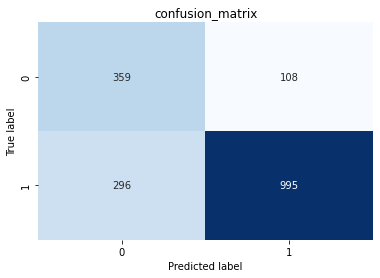

In [40]:
# plot confusion matrix
ens_cm = confusion_matrix(y_test, pred_mode)
sns.heatmap(ens_cm, fmt='g', cbar=False, annot=True, cmap='Blues')
plt.title('confusion_matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()